# Python project extension - 1000 agents

Name: Lukas Buhmann

ANR: 111321

SNR: 2008214

The code is the same as in the "assignment" script. The model solution is structured analogously. The solutions for the <a href='#scenario1'>baseline regime</a>, the <a href='#scenario2'>good state regime</a> and the <a href='#scenario2'>bad state regime</a> can be found with the previous links. Further properties of the model calibrations can be found <a href='#solving'>here</a>.

In [37]:
import scipy as sc
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

In [38]:
def optimal_bequest(inc):
    y = a * inc
    return y 

In [39]:
def Profit(talent, capital, wage):
    p = (1- beta)*(talent * capital**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) 
    return p

In [40]:
def a_opt(talent, wage, interest_rate):
    p = (talent*(beta/wage)**beta * (alpha/(1 + interest_rate))**(1-beta))**(1/(1-alpha-beta))
    return p

def n_opt(talent, wage, cap_opt):
    p = ((beta*talent*cap_opt**alpha)/wage)**(1/(1-beta))
    return p 

In [41]:
def profit_unconstrained(talent, capital, wage, interest_rate):
    p = (1- beta)*((talent *  capital**alpha)**(1/(1-beta))) * ((beta/wage)**(beta/(1-beta))) - (1+ interest_rate)*capital
    return p

def optimal_capital_unconstrained(talent,  wage, interest_rate):
    q1 =  sc.optimize.fminbound(lambda capital: -profit_unconstrained(talent, capital, wage, interest_rate),0,1000)
    return q1

def optimal_profit_unconstrained(talent,  wage, interest_rate):
    p = (1- beta)*(talent * optimal_capital_unconstrained(talent, wage, interest_rate)**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+ interest_rate)*optimal_capital_unconstrained(talent, wage, interest_rate)
    return p

In [42]:
def Profit_constrained(cap, talent, wage, interest_rate):
    p = (1- beta) * (talent * (cap[0]+cap[1])**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate)*cap[0] - (1+interest_rate+tau)*cap[1]
    return p


def optimal_capital_constrained(bequest, talent, wage, interest_rate):
    
    def cons1(cap, bequest):
            p = bequest - cap[0] -  0*cap[1]
            return p 

    def cons2(cap, talent, wage, interest_rate):
            p = phi*Profit_constrained(cap, talent, wage, interest_rate) - (1+interest_rate+tau)*cap[1]
            return p
    
    cons = ({'type': 'ineq', 'fun': lambda cap: cons1(cap,bequest)}, 
            {'type': 'ineq', 'fun': lambda cap: np.array([cons2(cap, talent, wage, interest_rate)])})
 
    bnds = ((0, 100), (0, 100))
 
    res =  sc.optimize.minimize(lambda cap: -Profit_constrained(cap,talent,wage,interest_rate),
                                x0 = [2,2],
                                constraints=cons, 
                                method='SLSQP',bounds = bnds)
    return res.x

def optimal_profit_constrained(bequest,talent, wage, interest_rate): 
    return Profit_constrained(optimal_capital_constrained(bequest, talent, wage, interest_rate),talent,wage,interest_rate)



In [43]:
def program_loop(bequests,talents,wage,interest_rate):
    income = np.array([])
    ent_unc_indicator = np.array([])
    ent_con_indicator = np.array([])
    wor_indicator = np.array([])
    ent_indicator = np.ones(len(bequests))
    for i in range(len(talents)):
        if bequests[i] >= a_opt(talents[i] , wage, interest_rate):
            income = np.append(income, optimal_profit_unconstrained(talents[i],wage,interest_rate))
            ent_unc_indicator = np.append(ent_unc_indicator,1)
            wor_indicator = np.append(wor_indicator,0)
            ent_con_indicator = np.append(ent_con_indicator,0)
            ent_indicator[i] = 1
        else:
            income = np.append(income, optimal_profit_constrained(bequests[i],talents[i],wage,interest_rate))
            ent_unc_indicator = np.append(ent_unc_indicator,0)
            wor_indicator = np.append(wor_indicator,0)
            ent_con_indicator = np.append(ent_con_indicator,1)
            ent_indicator[i] = 1
    for i in range(len(talents)):
        if income[i] < wage:
            income[i] = wage
            ent_con_indicator[i] = 0
            ent_unc_indicator[i] = 0
            wor_indicator[i] = 1
            ent_indicator[i] = 0
    return income, ent_unc_indicator, wor_indicator, ent_con_indicator, ent_indicator

In [44]:
def labor_marketclearing(bequests,talents, wage, interest_rate,ent_indicator_1, wor_indicator_1):
    labor_clearing = []
    for i in range(len(talents)):
        if ent_indicator_1[i] == 1:
                p = -n_opt(talents[i], wage, sum(optimal_capital_constrained(bequests[i],talents[i],wage, interest_rate)))
                labor_clearing.append(p)
        elif wor_indicator_1[i] ==1:
                p = 1
                labor_clearing.append(p)
    return sum(labor_clearing)

def cap_marketclearing(bequests, talents, wage, interest_rate,ent_indicator_1, wor_indicator_1):
    capital_clearing = []
    for i in range(len(talents)):
        if ent_indicator_1[i] == 1:
                p = bequests[i] - sum(optimal_capital_constrained(bequests[i],talents[i],wage, interest_rate))
                capital_clearing.append(p)
        elif wor_indicator_1[i] ==1:
                p = bequests[i]
                capital_clearing.append(p)
    return sum(capital_clearing)


def func(prices,bequests, talents, ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    
    F = np.empty(2)
    F[0] = labor_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)
    F[1] = cap_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)
    return F

def clear_all(prices,bequests, talents, ent_indicator_1, wor_indicator_1): 
    
    res = sc.optimize.root(func, args = (bequests,talents, ent_indicator_1, wor_indicator_1) , method = 'lm',tol=0.00002,x0 = (0.1,0.2))
    return res.x

def avfunc(prices,bequests, talents, ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    
    F = np.empty(2)
    F[0] = labor_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)/sum(wor_indicator_1)
    F[1] = cap_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)/sum(bequests)
    return F
 

def converge(prices,bequests,talents, new_prices,avlabor,avcapital,ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    w = new_prices[0]
    r = new_prices[1]
    
    p = np.empty(2)
    p[0] = (w - wage)/avlabor
    p[1] = (r - interest_rate)/avcapital
    
    return p

In [45]:
def generate_income(income,bequests,interest_rate):
        new_income = np.array([])
        for i in xrange(number_agents):
            new_income = np.append(new_income, income[i] + (1+interest_rate)*bequests[i])       
        return new_income   
    
def generate_bequest(income):
        new_bequest = np.array([])
        for i in xrange(number_agents):
            new_bequest = np.append(new_bequest, optimal_bequest(income[i]))   
        return new_bequest

# Solving the model - 1000 agents <a id='solving'></a>

I now construct and solve the model by means of the functions I created above. The function "simulation" which can be found below establishes a dynamic loop over the different steps programmed in the previous steps. For a better understanding, I annotated the code. The loop ends if an ex-ante defined condition is found to be true. That is, two subsequent wage rates and two subsequent interest rates must not deviate from each other by more than $1 \%$. This I define to be the steady state of the model. Additionally, there might be the case that the algorithm does not stop due to the first criterium. In this case, I define the state of the model reached after $40$ periods of time to be a good approximation for the steady state.

The talents are drawn from a cumulative exponential distribution of the form $F(x) = x^{\frac{1}{4.422}}$. As an initial bequest distribution, I choose a uniform distribution with $0.05$ units of initial capital endowment for each agent. This I do because otherwise, the high number of agents inflates the overall sum of bequests in the first periods, which leads to convergence problems.


The initial wage $w_0$ and initial interest rate $r_0$ are chosen to be $0.3$. 


In [46]:
def simulation(number_agents,w0,r0,b0=0.05, tol = 0.01, max_t_loops=40):
    
    #initialization of variables
    
    

    w = np.zeros(max_t_loops+1)
    r = np.zeros(max_t_loops+1)
    wstar = np.zeros(max_t_loops)
    rstar = np.zeros(max_t_loops)

    income_1  = np.zeros(shape = (max_t_loops,number_agents))
    ent_unc_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    wor_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    ent_con_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    ent_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    
    ndincome =  np.zeros(shape = (max_t_loops,number_agents))
    ndtalents = np.zeros(shape = (max_t_loops,number_agents))
    ndbequests = np.zeros(shape = (max_t_loops+1,number_agents))
    entind = np.zeros(max_t_loops) 

    
    #Loop the program over time

    t=1
    while True: 
        print t
        
        #Determine talent dist. per period
        ndtalents[t,:]=np.random.power(1/4.422,number_agents)
        #determine initial bequest dist.
        ndbequests[1,:].fill(b0)
        #determine initial wage and ir
        w[1] = w0
        r[1] = r0

        #occupational choice
        [income_1[t,:], ent_unc_indicator_1[t,:], wor_indicator_1[t,:],
        ent_con_indicator_1[t,:], ent_indicator_1[t,:]] = program_loop(ndbequests[t,:], ndtalents[t,:],w[t],r[t])
        
        #find root of the labor and capital market clearing function
        wstar[t], rstar[t] = clear_all([w[t], r[t]],ndbequests[t,:], ndtalents[t,:], ent_indicator_1[t,:], wor_indicator_1[t,:])
        
        #smooth the time paths of wage and interest rate
        excess = np.ndarray(shape = (1, 2))
        excess = avfunc([w[t],r[t]], ndbequests[t,:],ndtalents[t,:], ent_indicator_1[t,:], wor_indicator_1[t,:])

        conv = np.ndarray(shape = (1, 2))
        conv = converge([w[t],r[t]],ndbequests[t,:], ndtalents[t,:], [wstar[t], rstar[t]],excess[0],excess[1], ent_indicator_1[t,:], wor_indicator_1[t,:])

        w[t+1] = w[t] + sigma* conv[0]*excess[0]

        r[t+1] = r[t] + sigma* conv[1]*excess[1]
        
        #generate agents' income
        ndincome[t,:] = generate_income(income_1[t,:],ndbequests[t,:],r[t])
        
        #generate next period's bequest distribution
        ndbequests[t+1,:] = generate_bequest(ndincome[t,:])
        
        #determine share of enterpreneurs
        entind[t]=sum(ent_indicator_1[t,:])/number_agents
        
        #stop loop condition
        if abs((w[t+1]-w[t])/w[t])< tol and abs((r[t+1]-r[t])/r[t]) < tol:
            print 'break'
            print t
            break
            
        if t == max_t_loops - 1:
            break
            
        if r[t+1]>10:
            print 'non-convergence'
            break

        t+=1

    #determine final loop number
    nn=np.sum(w>0)
    nn=nn+1
    
    #adjust the variables to final loop number
    w = w[:nn]
    r = r[:nn]
    

    ndincome = ndincome[:nn,:]
    ndtalents = ndtalents[:nn,:]
    ndbequests = ndbequests[:nn,:]

    return w, r,ndincome,ndbequests,entind,nn, wstar, rstar, income_1, ent_unc_indicator_1, wor_indicator_1, ent_con_indicator_1, ent_indicator_1

## Baseline scenario - Calibration <a id='scenario1'></a>

The next window shows the parameter calibration I use for the baseline scenario analogous to the calibration of Antunes et al. (2008b):

$$ a = (1-  \gamma ) = 0.06 $$ 
$$b = \gamma = 0.94 $$
$$beta = \beta = 0.55$$
$$alpha = \alpha = 0.35$$ 
$$phi = \phi = 0.26$$ 
$$tau = \tau = 0.005 $$ 

 

 

  


Additionally, I choose $\sigma = 0.2 $. All parameter values except for $\tau$ and $\phi$ stay the same across all scenarios. In this script, I calibrate the model with 1000 agents. 


In [47]:
phi = 0.26
tau = 0.005
a = 0.06

beta = 0.55
alpha = 0.35

sigma = 0.2

In [31]:
number_agents = 1000
w0=0.3
r0=0.3
w, r,ndincome,ndbequests,entind,nn, wstar, rstar, income_1, ent_unc_indicator_1, wor_indicator_1, ent_con_indicator_1, ent_indicator_1 = simulation(number_agents,w0,r0)

1
2
3
4
5
6
7
8


C:\Users\Lukas\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Lukas\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
break
25


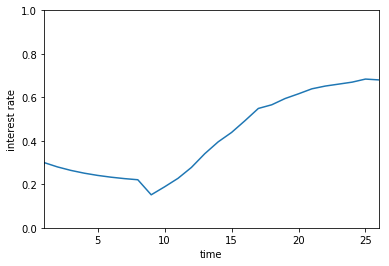

the steady state interest rate is: 0.68014604643
the steady wage is: 0.0688088211929
the share of enterpreneurs is :  0.094 for period 24 and 0.088 for period 25


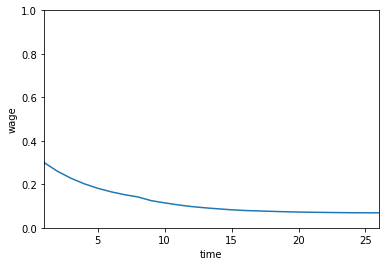

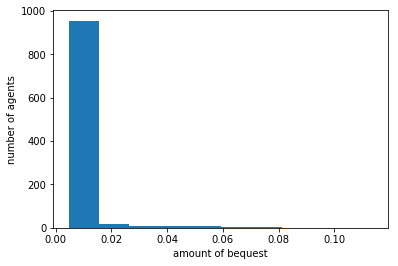

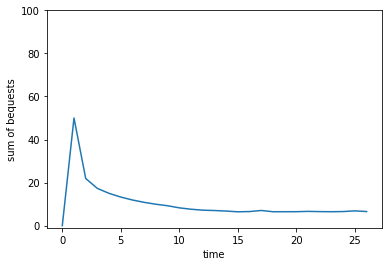

the steady state sum over all bequests is:  6.55592236994


In [32]:
plt.plot(r)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn-1])
plt.show()

print "the steady state interest rate is:", r[nn-1]
print "the steady wage is:", w[nn-1]

print 'the share of enterpreneurs is : ',  entind3[nn3-3], 'for period', nn-3 , 'and', entind3[nn3-2], 'for period', nn-2 

plt.plot(w)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn-1])
plt.show()


plt.hist(ndbequests[len(w)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests)):
    
    p = sum(ndbequests[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes = plt.gca()
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn-1]

# Solving the model: Better financial system scenario <a id='scenario2'></a>

In this calibration, the financial frictions are relaxed. The new financial frictions parameters are:
$$ \phi = 2 \times \phi_{baseline}$$

$$\tau = \frac{1}{2} \times \tau_{baseline} $$

In [34]:
phi = 0.52
tau = 0.0025

In [35]:
number_agents = 1000
w0=0.3
r0=0.3
w2, r2,ndincome2,ndbequests2,entind2, nn2, wstar2, rstar2, income_2, ent_unc_indicator_2, wor_indicator_2, ent_con_indicator_2, ent_indicator_2 = simulation(number_agents,w0,r0, tol =0.01, max_t_loops=40)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
break
31


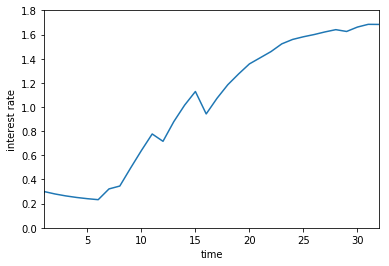

the steady state interest rate is: 1.68348736054
the steady wage is: 0.0674897524349
the share of enterpreneurs is :  0.082 for period 30 and 0.074 for period 31


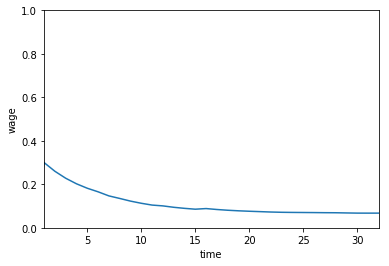

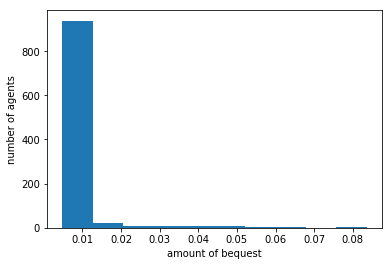

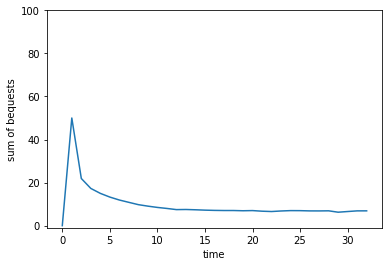

the steady state sum over all bequests is:  6.87571448014


In [53]:
plt.plot(r2)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([0,1.8])
axes.set_xlim([1,nn2-1])
plt.show()

print "the steady state interest rate is:", r2[nn2-1]
print "the steady wage is:", w2[nn2-1]

print 'the share of enterpreneurs is : ',  entind2[nn2-3], 'for period', nn2-3 , 'and', entind2[nn2-2], 'for period', nn2-2 

plt.plot(w2)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn2-1])
plt.show()


plt.hist(ndbequests2[len(w2)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests2)):
    
    p = sum(ndbequests2[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
axes = plt.gca()
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn2-1]

# The bad scenario <a id='scenario3'></a>

In this scenario, financial frictions are tightened. The new financial frictions parameters are:
    
$$ \phi = \frac{1}{2} \times \phi_{baseline}$$

$$\tau = 2 \times \tau_{baseline} $$

As I know from previous executions that $w_{steady state} \approx 0.07 $ and $r_{steady state} \approx -0.01$ I choose $w_0 = r_0 = 0.05 $. This drastically reduces computation time.

In [62]:
phi = 0.13
tau = 0.01

In [65]:
number_agents = 1000
w0=0.05
r0=0.05
w3, r3,ndincome3,ndbequests3,entind3, nn3, wstar3, rstar3, income_3, ent_unc_indicator_3, wor_indicator_3, ent_con_indicator_3, ent_indicator_3 = simulation(number_agents,w0,r0, tol = 0.01)

1
2
3


C:\Users\Lukas\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Lukas\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


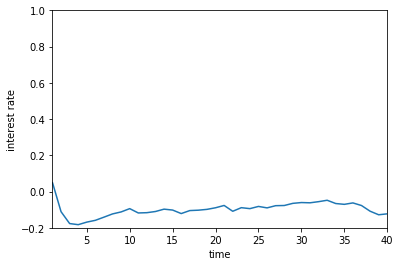

the steady state interest rate is: -0.122934109777
the steady wage is: 0.0691215356991
the share of enterpreneurs is :  0.092 for period 38 and 0.081 for period 39


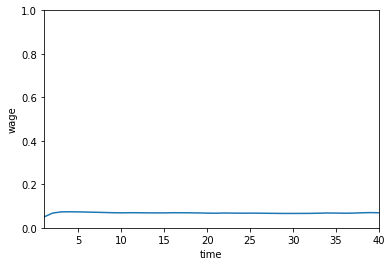

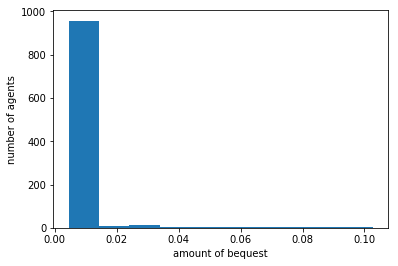

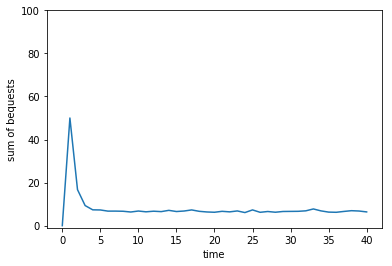

the steady state sum over all bequests is:  6.3771724313


In [69]:
plt.plot(r3)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([-0.2,1])
axes.set_xlim([1,nn3-1])
plt.show()

print "the steady state interest rate is:", r3[nn3-1]
print "the steady wage is:", w3[nn3-1]

print 'the share of enterpreneurs is : ', entind3[nn3-3], 'for period', nn3-3 , 'and', entind3[nn3-2], 'for period', nn3-2 

plt.plot(w3)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn3-1])
plt.show()


plt.hist(ndbequests3[len(w3)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests3)):
    
    p = sum(ndbequests3[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
axes = plt.gca()
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn3-1]

## Results

- The wage and interest rate dynamics are analogous to those in the "assignment" script

- Bequest distribution seems to be very similar across regimes.

- Sum over all bequests is lowest in the bad regime, and highest for the good regime (in line with expectations).

- Model dynamics seem to be smoother than in the 500 agents case

- the steady state definition leads to problems in the bad scenario, as the steady state cannot be identified in most code executions.






## References <a id='references'></a>

[1] Antunes, A., Cavalcanti, T., & Villamil, A. (2008). Computing general equilibrium models with occupational choice and financial frictions. Journal of Mathematical Economics, 44(7), 553-568.

[2] Antunes, A., Cavalcanti, T., & Villamil, A. (2008). The effect of financial repression and enforcement on entrepreneurship and economic development. Journal of Monetary Economics, 55(2), 278-297.